In [1]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
%matplotlib inline

def values(func, left, right, n):
    return func(np.linspace(left, right, n))

In [2]:
def wtt_filter(input_vector, d, modes, ranks=None, eps=None, check_correctness=False):
    assert ranks is not None or eps is not None
    
    filters = []
    prod_modes = input_vector.size
    
    if check_correctness:
        assert len(modes) == d
        if ranks is not None:
            assert len(ranks) == d - 1
        if eps is not None:
            assert 0 <= eps <= 1
        assert prod_modes == np.prod(modes)
        
    true_ranks = []
    
    r_prev = 1
    A = input_vector
    for k in range(d):
        A = A.reshape((r_prev * modes[k], prod_modes // modes[k]), order='F')
        if A.shape[0] <= A.shape[1]:
            u, sigmas, vt = np.linalg.svd(A, full_matrices=False)
        else:
            u, sigmas, vt = np.linalg.svd(A, full_matrices=True)
            
        r_given = None if ranks is None else (1 if k == d - 1 else ranks[k])
        r_eps = None if eps is None else max(1, (sigmas >= eps * sigmas[0]).sum())
        if r_given is not None and r_eps is not None:
            r_cur = min(r_given, r_eps)
        elif r_given is not None:
            r_cur = r_given
        else:
            r_cur = r_eps
        
        filters.append(u)

        if check_correctness:
            assert u.shape[0] == u.shape[1] == r_prev * modes[k]
            if k < d - 1:
                assert r_cur <= r_prev * modes[k]

        if k < d - 1:
            A = (u.T @ A)[:r_cur,:]
            prod_modes //= modes[k]
            true_ranks.append(r_cur)
            r_prev = r_cur
    
    return filters, true_ranks

def wtt_apply(input_vector, d, filters, modes, ranks, check_correctness=False):
    prod_modes = input_vector.size
    
    if check_correctness:
        assert len(filters) == d
        assert len(modes) == d
        assert len(ranks) == d - 1
        assert prod_modes == np.prod(modes)
        
    tails = []
    A = input_vector
    r_prev = 1
    for k in range(d):
        A = A.reshape((r_prev * modes[k], prod_modes // modes[k]), order='F')
        A = filters[k].T @ A

        if check_correctness:
            assert A.shape[0] == r_prev * modes[k]
            if k < d - 1:
                assert ranks[k] <= r_prev * modes[k]
                
        if k < d - 1:
            tails.append(A[ranks[k]:,:])
            A = A[:ranks[k],:]
            prod_modes //= modes[k]
            r_prev = ranks[k]
        
    result = A
    for k in range(d - 2, -1, -1):        
        result = np.vstack([
            result.reshape((ranks[k], prod_modes), order='F'),
            tails[k]
        ])
        prod_modes *= modes[k]
    
    return result.flatten(order='F')

def iwtt_apply(input_vector, d, filters, modes, ranks, check_correctness=False):
    prod_modes = input_vector.size
    
    if check_correctness:
        assert len(filters) == d
        assert len(modes) == d
        assert len(ranks) == d - 1
        assert prod_modes == np.prod(modes)
        
    tails = []
    A = input_vector
    r_prev = 1
    for k in range(d):
        A = A.reshape((r_prev * modes[k], prod_modes // modes[k]), order='F')

        if check_correctness:
            assert A.shape[0] == r_prev * modes[k]
            if k < d - 1:
                assert ranks[k] <= r_prev * modes[k]
                
        if k < d - 1:
            tails.append(A[ranks[k]:,:])
            A = A[:ranks[k],:]
            prod_modes //= modes[k]
            r_prev = ranks[k]
        
    #prod_modes == modes[-1] в конце
    result = A
    for k in range(d - 1, -1, -1):
        
        r_prev = 1 if k == 0 else ranks[k - 1]
        if k == d - 1:
            result = (filters[k] @ result).reshape((r_prev, prod_modes), order='F')
        else:
            result = (filters[k] @ np.vstack([
                result,
                tails[k]
            ])).reshape((r_prev, prod_modes), order='F')
        prod_modes *= modes[k]
    
    return result.flatten(order='F')

In [3]:
d = 20
n = 2 ** d
left = 0.
right = 1.

sin_values = values(lambda x: np.sin(100 * x), left, right, n)

In [4]:
filters, true_ranks = wtt_filter(
    sin_values,
    d,
    [2] * d,
    [2] * (d - 1),
    0.,
    True
)

wtt_result = wtt_apply(
    sin_values,
    d,
    filters,
    [2] * d,
    true_ranks,
    True
)

print(true_ranks)

wtt_result = np.abs(wtt_result)
print(wtt_result[0]) #первый элемент большой
wtt_result[0] = 0
amax = np.argmax(wtt_result)
print(amax, wtt_result[amax])
wtt_result[amax] = 0
amax = np.argmax(wtt_result)
print(amax, wtt_result[amax])

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
725.6562012962519
196608 9.013884240848282e-14
163840 7.635483989879115e-14


Попробуем теперь сравниться со статьёй.

После гугления выяснилось, что db$N$ соответствует D$2N$.

In [5]:
w = pywt.Wavelet('db2') #D4
print(w)
#cA, cD = pywt.dwt(sin_values, wavelet=w)
#print(cA.size, cD.size)

Wavelet db2
  Family name:    Daubechies
  Short name:     db
  Filters length: 4
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       asymmetric
  DWT:            True
  CWT:            False


In [14]:
phi, psi, x = w.wavefun()
#print(x)
print(x.size, x[0], x[-1])
print(np.allclose(x, np.linspace(x[0], x[-1], x.size)))

769 0.0 3.0
True


In [21]:
dec = pywt.wavedec(sin_values, w, level = d - 1)
print(len(dec))

20


C:\Users\kdi20\anaconda3\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 19 is too high: all coefficients will experience boundary effects.
  warnings.warn(


In [22]:
all_coefs = np.concatenate(dec)
all_coefs.size

1048615

In [23]:
for p in range(4, 13, 2):
    eps = 10 ** (-p)
    print(eps, (np.abs(all_coefs) > eps).sum())

0.0001 13147
1e-06 66945
1e-08 465905
1e-10 1042108
1e-12 1048555


Не совсем понимаю, как интерпретировать $\varepsilon$ в таблице 4.1: если это порог, с которым сравнивается на 0 значение после преобразования, то рост есть, но не такой сильный, как в статье.

In [42]:
w = pywt.Wavelet('db4') #D8
print(w)

Wavelet db4
  Family name:    Daubechies
  Short name:     db
  Filters length: 8
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       asymmetric
  DWT:            True
  CWT:            False


In [43]:
dec = pywt.wavedec(sin_values, w)
print(len(dec))

18


In [44]:
all_coefs = np.concatenate(dec)
all_coefs.size

1048680

In [45]:
for p in range(4, 13, 2):
    eps = 10 ** (-p)
    print(eps, (np.abs(all_coefs) > eps).sum())

0.0001 1113
1e-06 3783
1e-08 8134
1e-10 28677
1e-12 63800


In [46]:
dec_manual = []
ca_latest = sin_values
while ca_latest.size > w.dec_len:
    ca, cd = pywt.dwt(ca_latest, w)
    dec_manual.append(cd)
    ca_latest = ca
dec_manual = [ca] + dec_manual

In [47]:
len(dec)

18

Просто играюсь с 2D:

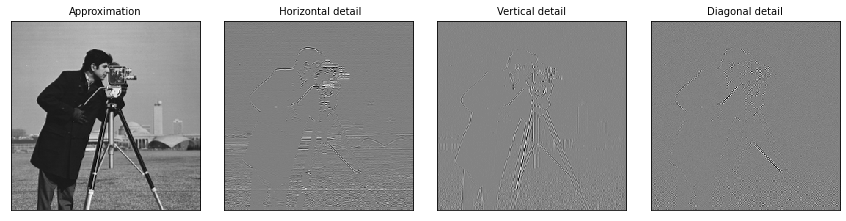

In [48]:
original = pywt.data.camera()

titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(original, 'db4')
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

In [49]:
def matrix_to_vector(A, d, modes, check_correctness=False):
    if check_correctness is True:
        assert A.shape[0] == A.shape[1] == np.prod(modes)
        assert len(modes) == d
    result = np.reshape(A, modes + modes, order='F')
    axes_transpose = []
    for i in range(d):
        axes_transpose.append(i)
        axes_transpose.append(d + i)
    result = np.transpose(result, axes_transpose)
    new_modes = [m ** 2 for m in modes]
    result = np.reshape(result, new_modes, order='F')
    return result.flatten(order='F'), new_modes

def vector_to_matrix(v, d, modes, check_correctness=False):
    if check_correctness is True:
        assert v.size == np.prod(modes)
        assert len(modes) == d
    new_modes = [int(np.sqrt(m)) for m in modes]
    if check_correctness is True:
        assert np.all(modes == np.square(new_modes))
    result = np.reshape(v, new_modes + new_modes, order='F')
    axes_transpose = []
    for i in range(d):
        axes_transpose.append(2 * i)
    for i in range(d):
        axes_transpose.append(2 * i + 1)
    result = np.transpose(result, axes_transpose)
    result = np.reshape(result, (np.prod(new_modes), np.prod(new_modes)), order='F')
    return result, new_modes

In [50]:
original.shape

(512, 512)

In [51]:
d = 9
n = 2 ** d
modes = [2] * d

img_tensorised, vector_modes = matrix_to_vector(original, d, modes, True)
assert vector_modes == [4] * d

In [52]:
eps = 1e-4
delta = 1e-6
    
filters, true_ranks = wtt_filter(img_tensorised, d, vector_modes, eps=eps)
wtt_res = wtt_apply(img_tensorised, d, filters, vector_modes, true_ranks)
print(wtt_res.size, (np.abs(wtt_res) < delta).sum())

wtt_res[np.abs(wtt_res) < delta] = 0

iwtt_res = iwtt_apply(wtt_res, d, filters, vector_modes, true_ranks)

img_compressed, _ = vector_to_matrix(iwtt_res, d, vector_modes, True)
assert _ == modes

262144 190463


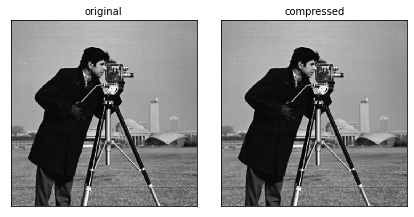

In [53]:
fig = plt.figure(figsize=(6, 3))
titles = ["original", "compressed"]
for i, a in enumerate([original, img_compressed]):
    ax = fig.add_subplot(1, 2, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()